In [1]:
import numpy as np
import scipy as sp
import functools as ft
import matplotlib.pyplot as plt
import pandas as pd
import time

import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.quantum_info import Operator

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Function

In [2]:
def measure_circuit(basis, num_qubits):

    basis_qb = re.findall(r'[A-Za-z]|-?\d+\.\d+|\d+', basis)
    basis = basis_qb[0:][::2] 
    qubit = list(map(int, basis_qb[1:][::2]))

    measure_qc = QuantumCircuit(num_qubits, num_qubits)
    for base, qb in zip(basis, qubit):
        if base == 'I' or base == 'Z':
            pass
        elif base == 'X':
            measure_qc.h(qb)
        elif base == 'Y':
            measure_qc.sdg(qb)
            measure_qc.h(qb)
        else:
            raise ValueError("Wrong Basis provided")
    
    for qb in range(num_qubits):
        measure_qc.measure(qb, qb)

    return measure_qc

def ansatz_TL(params, num_qubits): 
    
    ansatz = QuantumCircuit(num_qubits, num_qubits)
    
    ansatz.h(0)
    ansatz.rx(params[0],0)
    
    ansatz.h(1)
    ansatz.rx(params[1],1)
    
    ansatz.cz(0, 1)

    ansatz.h(0)
    ansatz.rx(params[2],0)
    
    ansatz.h(1)
    ansatz.rx(params[3],1)
        
    ansatz.cz(0, 1)

    ansatz.h(0)
    ansatz.rx(params[4],0)
    
    ansatz.h(1)
    ansatz.rx(params[5],1)
        
    ansatz.cz(0, 1)

    ansatz.h(0)
    ansatz.rx(params[6],0)
    
    ansatz.h(1)
    ansatz.rx(params[7],1)

    return ansatz

# Fungsi untuk mengambil perubahan parameter setiap iterasi
def collect_param(list_params,params):
    list_params.append(params)
    
def collect_energy(energy_list,energy):
    energy_list.append(energy) 
    
def collect_expec(expec_list,expec):
    expec_list.append(expec)
    
def calc_eval(circuit, basis, shots, backend='aer_simulator',print_result=0):
    m_circ = measure_circuit(basis, circuit.num_qubits)
    exp_circuit = circuit.compose(m_circ)
    
    backend = Aer.get_backend('aer_simulator')
    tqc = transpile(exp_circuit, backend)
    counts = backend.run(tqc, shots=shots).result().get_counts()
    
    exp = 0
    if basis == 'I0I1':
        exp = 1

    elif basis == 'I0Z1':
        for i in counts:
            if i == '01' or i == '11':
                sign = -1
            else:
                sign = 1
            C = counts[i] / shots
            s_C = sign * C
            exp += s_C

    elif basis == 'Z0I1':
        for i in counts:
            if i == '10' or i == '11':
                sign = -1
            else:
                sign = 1
            C = counts[i] / shots
            s_C = sign * C
            exp += s_C

    elif basis == 'Z0Z1':
        for i in counts:
            if i == '01' or i == '10':
                sign = -1
            else:
                sign = 1
            C = counts[i] / shots
            s_C = sign * C
            exp += s_C
    if print_result == 1:        
        print('\ncalc eval')
        print(text.format('Basis',basis))
        print(counts)
        print(text.format('exp',exp))
    return exp   

def vqe(params, meas_basis, coeffs, circuit, num_qubits, list_params, energy_list, expec_list, shots=4096,print_result=0):
    collect_param(list_params,params) 
    N = num_qubits
    circuit = circuit(params, num_qubits)
    energy = 0
    expec = []
    for basis, coeff in zip(meas_basis, coeffs):
        
        expec_val = calc_eval(circuit = circuit, basis = basis, shots = shots, print_result = print_result)
        expec.append(expec_val)
        
        c_expec =  coeff*expec_val
        energy += c_expec
        
        if print_result == 1:
            print('\nVQE')
            print(text.format('Basis',basis))
            print(text.format('Exp val',expec_val))
            print(text.format('C * Exp',c_expec))
            print(text.format('E',energy))
            print()
    collect_expec(expec_list,expec) 
    collect_energy(energy_list,energy)       
    return energy

def expec_plot(list_expec, title):
    I0I1_plot = []
    I0Z1_plot = []
    Z0I1_plot = []
    Z0Z1_plot = []
    iteration = [i for i in range(len(list_expec))]
    for i, j in enumerate(list_expec): 
        I0I1_plot.append(j[0])
        I0Z1_plot.append(j[1])
        Z0I1_plot.append(j[2])
        Z0Z1_plot.append(j[3])
        
    plt.plot(iteration,I0I1_plot,'-x',label=r'$II$')
    plt.plot(iteration,I0Z1_plot,'-o',label=r'$IZ$')
    plt.plot(iteration,Z0I1_plot,'-x',label=r'$ZI$')
    plt.plot(iteration,Z0Z1_plot,'-o',label=r'$ZZ$')
    plt.xlabel('Iteration')
    plt.ylabel('Expectation Value')
    plt.ylim(-1.1,1.1)
    plt.legend()
    plt.grid()
    plt.show()
    
def energy_plot(energy_list1, energy_list2, e_ref, ref_name, label = ''):
    iter1 = [i for i in range(len(energy_list1))]
    iter2 = [i for i in range(len(energy_list2))]
    
    plt.plot(iter1,energy_list1,'-o',color = 'red',label='STO-3G')
    plt.plot(iter2,energy_list2,'-o',color = 'blue',label=r'1$s$')
    plt.axhline(y = e_ref, color = 'black', label = '{:}'.format(ref_name))
    plt.margins(0.05, 0.05)
    plt.xlabel('Iterations')
    plt.ylabel('Energy (Hartree)')
    plt.legend()
    plt.grid()
    plt.show()
    
def ansatz_TL_m(params, num_qubits): 
    
    ansatz = QuantumCircuit(num_qubits, num_qubits)
    
    ansatz.h(0)
    ansatz.rx(params[0],0)
    
    ansatz.h(1)
    ansatz.rx(params[1],1)
    
    ansatz.cz(0, 1)
    
    ansatz.barrier()

    ansatz.h(0)
    ansatz.rx(params[2],0)
    
    ansatz.h(1)
    ansatz.rx(params[3],1)
        
    ansatz.cz(0, 1)
    
    ansatz.barrier()

    ansatz.h(0)
    ansatz.rx(params[4],0)
    
    ansatz.h(1)
    ansatz.rx(params[5],1)
        
    ansatz.cz(0, 1)
    
    ansatz.barrier()

    ansatz.h(0)
    ansatz.rx(params[6],0)
    
    ansatz.h(1)
    ansatz.rx(params[7],1)

    for idx in range(num_qubits):
        ansatz.measure(idx,idx)

    return ansatz

def ket_Psi_i_func(param,shots_input):
    
    ansatz_psi_i = ansatz_TL_m(param,2)
    
    backend = Aer.get_backend('aer_simulator')
    tqc = transpile(ansatz_psi_i, backend)
    counts = backend.run(tqc, shots=shots_input).result().get_counts()
    
    ket_Psi_i = np.zeros([4,1], dtype = np.complex128)
    for key, item in counts.items():
        prob = item/shots_input
        if key == '00':
            ket_Psi_i[0][0] += prob
        if key == '01':
            ket_Psi_i[1][0] += prob
        if key == '10':
            ket_Psi_i[2][0] += prob
        if key == '11':
            ket_Psi_i[3][0] += prob
            
    return ket_Psi_i

def ket_Psi_G_unitary(param):
    state00K = np.array([[1],[0],[0],[0]], dtype = np.complex128)
    ansatz_psi_G = ansatz_TL(param,2)
    U = Operator(ansatz_psi_G)
    ket_Psi_G = U._data @ state00K
    return ket_Psi_G

def state_overlap_func1(list_params1, list_params2, title):
    shots_input = 2048
    iter1 = [i for i in range(len(list_params1))]
    iter2 = [i for i in range(len(list_params2))]
    
    def state_over(list_params):
        state_overlap_plot = []
        for i, j in enumerate(list_params):
            # Psi I
            ket_Psi_i = ket_Psi_i_func(j,shots_input)
            bra_Psi_i = np.conjugate(ket_Psi_i).transpose()

            # Psi G
            ket_Psi_G = ket_Psi_G_unitary(j)

            braket = bra_Psi_i @ ket_Psi_G 
            state_overlap = braket * np.conjugate(braket.transpose())
            state_overlap_plot.append(state_overlap[0][0].real)
        return state_overlap_plot
    
    state_STO3G = state_over(list_params1)
    state_1s = state_over(list_params2)
    plt.plot(iter1,state_STO3G,'-o', color='red',label='STO-3G')
    plt.plot(iter2,state_1s,'-o', color='blue',label=r'1$s$')
    plt.xlabel('Iterations')
    plt.ylabel('State Overlap')
    plt.ylim(0,1.1)
    plt.legend()
    plt.grid()
    plt.show()
    
    return state_STO3G, state_1s

def parameter_plot(list_params, title):
    t0 = []
    t1 = []
    t2 = []
    t3 = []
    t4 = []
    t5 = []
    t6 = []
    t7 = []
    N = len(list_params)
    iter_ = [i for i in range(N)]
    for i in range(N):
        list_app = list_params[i]
        t0.append(list_app[0])
        t1.append(list_app[1])
        t2.append(list_app[2])
        t3.append(list_app[3])
        t4.append(list_app[4])
        t5.append(list_app[5])
        t6.append(list_app[6])
        t7.append(list_app[7])
    
    #plot
    plt.plot(iter_,t0,'-o',label=r'$\theta_0$')
    plt.plot(iter_,t1,'-x',label=r'$\theta_1$')
    plt.plot(iter_,t2,'-o',label=r'$\theta_2$')
    plt.plot(iter_,t3,'-x',label=r'$\theta_3$')
    plt.plot(iter_,t4,'-o',label=r'$\theta_4$')
    plt.plot(iter_,t5,'-x',label=r'$\theta_5$')
    plt.plot(iter_,t6,'-o',label=r'$\theta_6$')
    plt.plot(iter_,t7,'-x',label=r'$\theta_7$')
    plt.xlabel('Iterations')
    plt.ylabel('Parameter Value')
    plt.legend()
    plt.grid()
    plt.show()

# Initialize Qubit Hamiltonian
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
<!-- $$\bra{\Psi}\Omega\ket{\Psi}$$
$$\braket{\Psi}{\Psi}$$ -->

In [3]:
qubit_H_component = ['I0I1','I0Z1','Z0I1','Z0Z1']

In [4]:
H_STO3G = [-0.03963943879866322,0.03963943879866322,-0.19365148597997445,0.19365148597997445] 
He_STO3G = [-1.667820214453755,0.7019459893849935,0.7019459893849935,0.26392823568376805]

In [5]:
H_1s = [-0.09375,0.09375,-0.15625,0.15625]
He_1s = [-1.6875,0.7119140625,0.7119140625,0.263671875]  

In [6]:
init_param1 = [2.39209694, 3.96294615, 4.61796939, 4.36094702, 6.89506863, 6.19228944, 7.32517049, 5.08146707]
init_params_H = np.array(init_param1)
init_param2 = [3*np.pi, np.pi, 3*np.pi, 7/2*np.pi, 2*np.pi, 3*np.pi, 3*np.pi, 7/2*np.pi]
init_params_He = np.array(init_param2)

In [7]:
method_min = 'COBYLA'
shots_calculation = 4096 * 2

In [8]:
def run_func(meas_basis, coeffs_STO3G, coeffs_1s, circuit, init_params, e_ref, ref_name, num_qubits = 2, title = '1. H STO3G - 1s', label = ''):
    start_time = time.time()
    
    #STO3G
    list_params_STO3G = []
    energy_list_STO3G = []
    expec_list_STO3G = []
    func1 = ft.partial(vqe, 
                      meas_basis=meas_basis, 
                      coeffs=coeffs_STO3G, 
                      circuit=circuit, 
                      num_qubits=num_qubits, 
                      list_params = list_params_STO3G,
                      energy_list = energy_list_STO3G,
                       expec_list = expec_list_STO3G,
                      shots=shots_calculation, print_result = 0)
    res1 = sp.optimize.minimize(func1, x0 = init_params,method=method_min)
    E_opt_STO3G = res1.fun
    opt_params_STO3G = res1.x
    N_iter_STO3G = res1.nfev
    
    #1s Orbital
    list_params_1s = []
    energy_list_1s = []
    expec_list_1s = []
    func2 = ft.partial(vqe, 
                      meas_basis=meas_basis, 
                      coeffs=coeffs_1s, 
                      circuit=circuit, 
                      num_qubits=num_qubits, 
                      list_params = list_params_1s,
                      energy_list = energy_list_1s,
                       expec_list = expec_list_1s,
                      shots=shots_calculation, print_result = 0)
    res2 = sp.optimize.minimize(func2, x0 = init_params,method=method_min)
    E_opt_1s = res2.fun
    opt_params_1s = res2.x
    N_iter_1s = res2.nfev
    
    print(title)
    
    print('STO3G')
    print('E opt:\n',E_opt_STO3G)
    print('N iter:\n',N_iter_STO3G)
    print('init param:\n',init_params)
    print('opt param:\n',opt_params_STO3G)
    display(ansatz_TL(opt_params_STO3G,2).draw(style='clifford'))
    
    print('1s')
    print('E opt:\n',E_opt_1s)
    print('N iter:\n',N_iter_1s)
    print('init param:\n',init_params)
    print('opt param:\n',opt_params_1s)
    display(ansatz_TL(opt_params_1s,2).draw(style='clifford'))
    
    print('Expectation Plot', title)
    print('STO3G')
    expec_plot(list_expec = expec_list_STO3G, title = title)
    print('1s')
    expec_plot(list_expec = expec_list_1s, title = title)
    
    print('Energy Plot', title)
    energy_plot(energy_list_STO3G, energy_list_1s, e_ref, ref_name)
    
    print('State Plot Simulator vs Theoretical', title)
    state_STO3G, state_1s = state_overlap_func1(list_params_STO3G, list_params_1s, title = title)

    print('Parameter STO3G', title)
    parameter_plot(list_params = list_params_STO3G, title = title)
    
    print('Parameter 1s', title)
    parameter_plot(list_params = list_params_1s, title = title)
    
    end_time = time.time()
    exec_time = (end_time-start_time) #s
    text = '{:^5.2f} {:}'
    time.sleep(3)
    print("The time of execution of above program is :")
    print(text.format(exec_time, "s"))
    print(text.format(exec_time/60, "min"))
    a = (E_opt_STO3G, N_iter_STO3G, opt_params_STO3G, list_params_STO3G, energy_list_STO3G, expec_list_STO3G, state_STO3G)
    b = (E_opt_1s, N_iter_1s, opt_params_1s, list_params_1s, energy_list_1s, expec_list_1s, state_1s) 
    
    #save list
    data_STO3G = pd.DataFrame({'params': list_params_STO3G, 
                               'expec': expec_list_STO3G,
                               'energy': energy_list_STO3G,
                               'state': state_STO3G,
                               })
    
    data_1s = pd.DataFrame({'params': list_params_1s, 
                               'expec': expec_list_1s,
                               'energy': energy_list_1s,
                               'state': state_1s,
                               })
    
    data_STO3G.to_excel(title + ' STO3G.xlsx')
    data_1s.to_excel(title + ' 1s.xlsx')
    
    return a, b

1. H
STO3G
E opt:
 -0.46484969195969517
N iter:
 106
init param:
 [2.39209694 3.96294615 4.61796939 4.36094702 6.89506863 6.19228944
 7.32517049 5.08146707]
opt param:
 [2.1159302  5.40671237 4.64461562 4.78082442 6.4280598  6.14612919
 7.82488939 4.69490398]


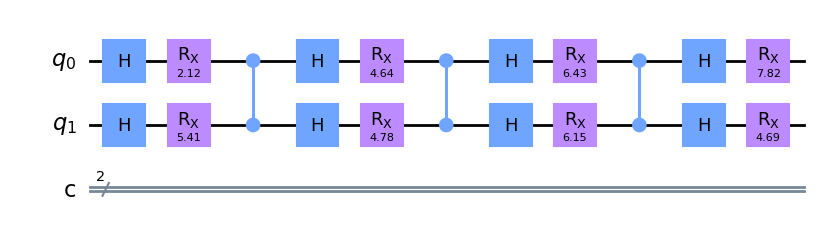

1s
E opt:
 -0.49996185302734375
N iter:
 98
init param:
 [2.39209694 3.96294615 4.61796939 4.36094702 6.89506863 6.19228944
 7.32517049 5.08146707]
opt param:
 [3.43575443 3.63155098 4.69724206 4.72775238 6.76073213 5.79862964
 7.85279382 4.71232715]


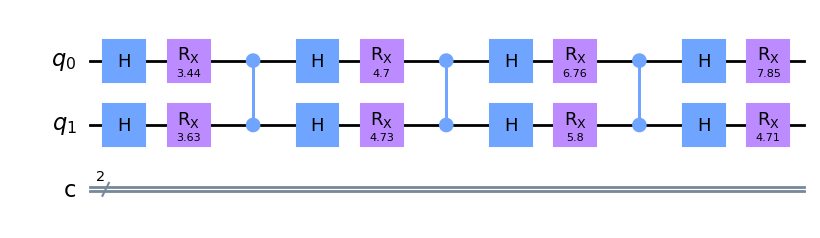

Expectation Plot 1. H
STO3G


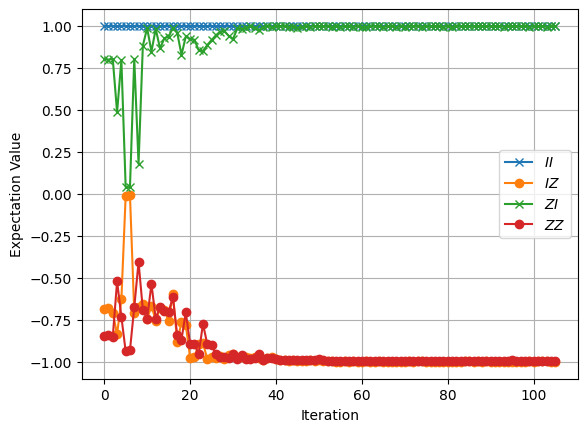

1s


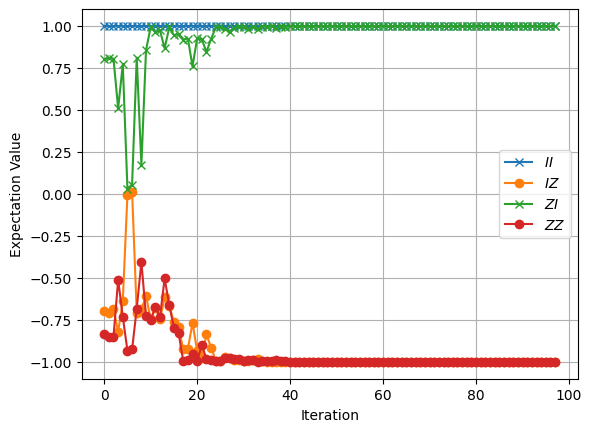

Energy Plot 1. H


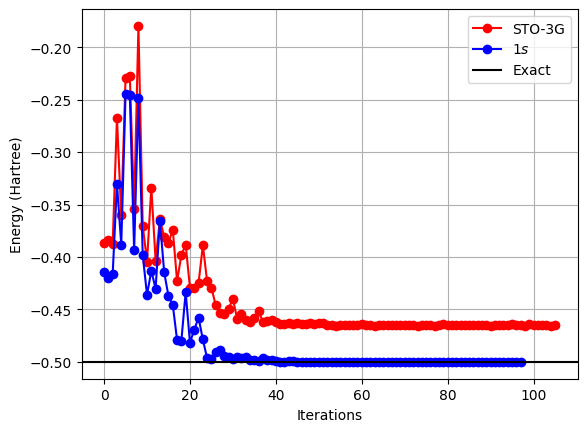

State Plot Simulator vs Theoretical 1. H


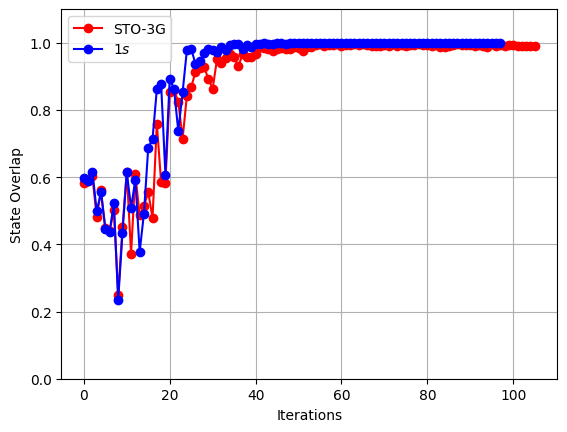

Parameter STO3G 1. H


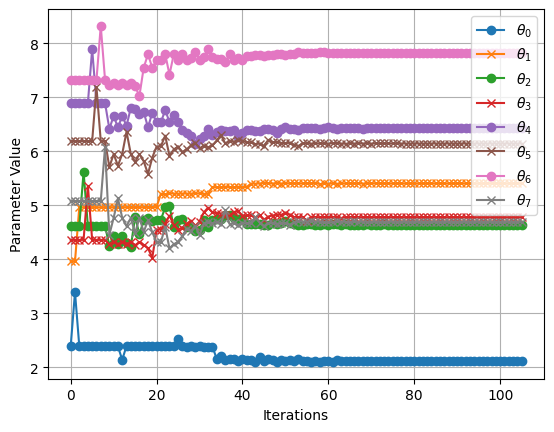

Parameter 1s 1. H


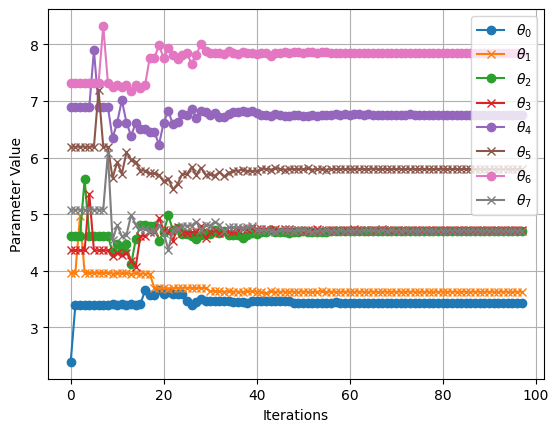

The time of execution of above program is :
80.28 s
1.34  min


In [9]:
res_H_STO3G, res_H_1s = run_func(meas_basis=qubit_H_component, coeffs_STO3G=H_STO3G, coeffs_1s=H_1s,  
                                 circuit=ansatz_TL, init_params=init_params_H, e_ref = -0.5, ref_name='Exact', 
                                 num_qubits = 2, title = '1. H')

2. He
STO3G
E opt:
 -2.8070559610859807
N iter:
 106
init param:
 [ 9.42477796  3.14159265  9.42477796 10.99557429  6.28318531  9.42477796
  9.42477796 10.99557429]
opt param:
 [10.82176665  3.8169524  11.00427986 10.96324199  6.40083182  9.30097568
 10.99576072 11.01459043]


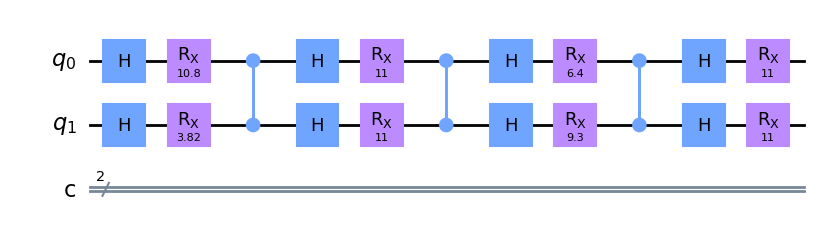

1s
E opt:
 -2.845860242843628
N iter:
 99
init param:
 [ 9.42477796  3.14159265  9.42477796 10.99557429  6.28318531  9.42477796
  9.42477796 10.99557429]
opt param:
 [10.32544935  4.11495932 10.91133687 11.00442217  6.19196984  9.51912813
 10.96277822 10.96169712]


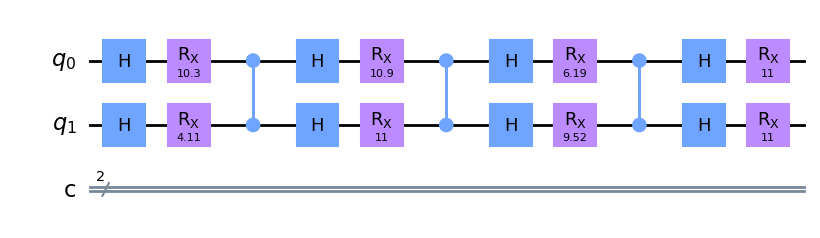

Expectation Plot 2. He
STO3G


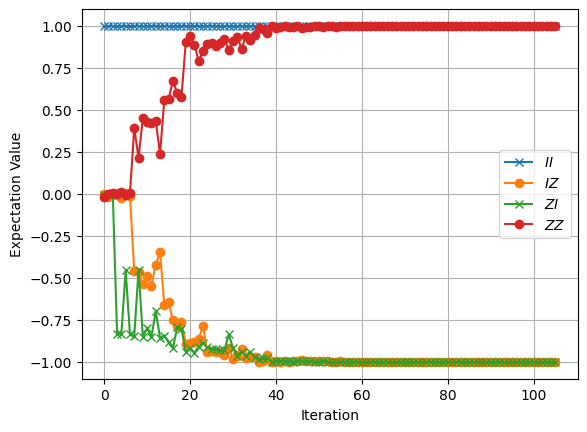

1s


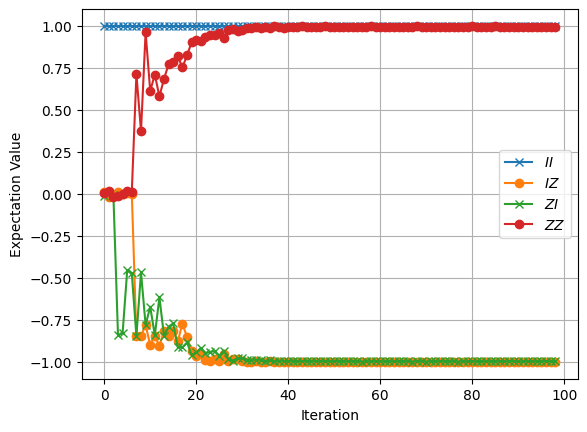

Energy Plot 2. He


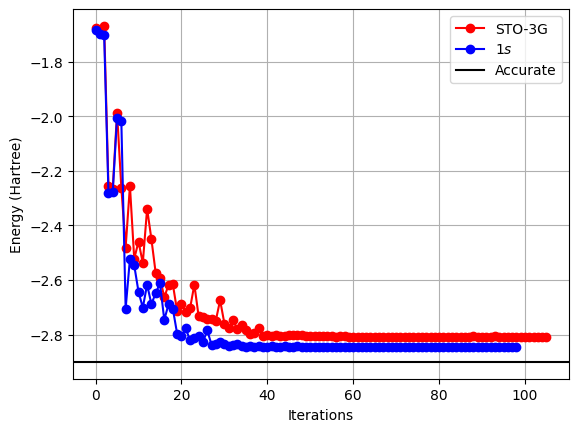

State Plot Simulator vs Theoretical 2. He


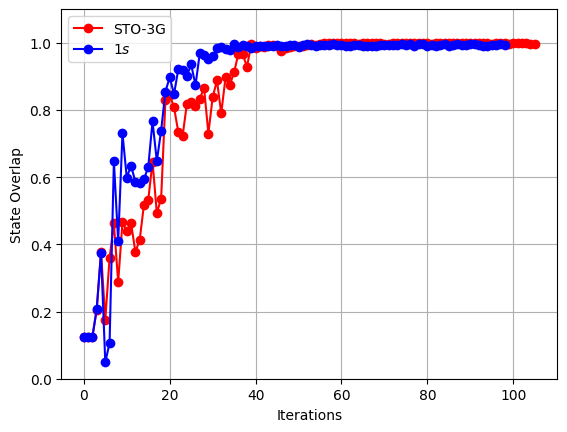

Parameter STO3G 2. He


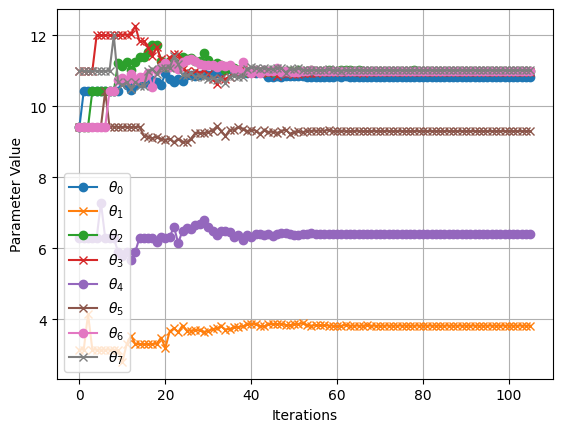

Parameter 1s 2. He


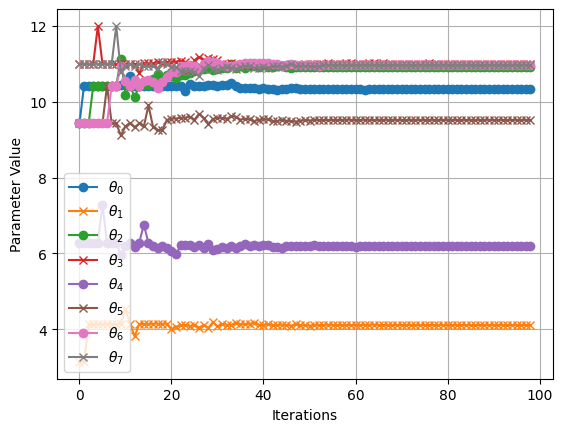

The time of execution of above program is :
67.86 s
1.13  min


In [10]:
res_He_STO3G, res_He_1s = run_func(meas_basis=qubit_H_component, coeffs_STO3G=He_STO3G, coeffs_1s=He_1s,  
                                   circuit=ansatz_TL, init_params=init_params_He, e_ref = -2.90, ref_name='Accurate', 
                                   num_qubits = 2, title = '2. He')

In [11]:
E_H_STO3G = [res_H_STO3G[0],res_He_STO3G[0],]
N_H_STO3G = [res_H_STO3G[1],res_He_STO3G[1],]
param_H_STO3G = [res_H_STO3G[2],res_He_STO3G[2],]

E_H_1s = [res_H_1s[0],res_He_1s[0],]
N_H_1s = [res_H_1s[1],res_He_1s[1],]
param_H_1s = [res_H_1s[2],res_He_1s[2],]

H_ref = [-0.5,-2.90]
H_sequence_atom = ['H','He']

In [12]:
head = '{:^5} | {:^10} | {:^10} | {:^10}'
rowf = '{:^5} | {:^10.6f} | {:^10.6f} | {:^10.2f}'
rowf2 = '{:^5} | {:^10.6f} | {:^10.6f} | {:^10.6f}'
print(head.format('Atom', 'STO-3G', '1s', 'Exact'))
for i, j in enumerate(H_sequence_atom):
    print(rowf.format(j,E_H_STO3G[i],E_H_1s[i],H_ref[i]))
    
print('\nIteration')
print_f = "{:7} :"
for i, j in enumerate(H_sequence_atom):
    print(j)
    print(print_f.format('STO-3G'),N_H_STO3G[i])
    print(print_f.format('1s'),N_H_1s[i],'\n')    
    
print('\nOptimized Parameter')
for i, j in enumerate(H_sequence_atom):
    print(j)
    print('STO-3G:\n',param_H_STO3G[i])
    print('1s:\n',param_H_1s[i],'\n') 

Atom  |   STO-3G   |     1s     |   Exact   
  H   | -0.464850  | -0.499962  |   -0.50   
 He   | -2.807056  | -2.845860  |   -2.90   

Iteration
H
STO-3G  : 106
1s      : 98 

He
STO-3G  : 106
1s      : 99 


Optimized Parameter
H
STO-3G:
 [2.1159302  5.40671237 4.64461562 4.78082442 6.4280598  6.14612919
 7.82488939 4.69490398]
1s:
 [3.43575443 3.63155098 4.69724206 4.72775238 6.76073213 5.79862964
 7.85279382 4.71232715] 

He
STO-3G:
 [10.82176665  3.8169524  11.00427986 10.96324199  6.40083182  9.30097568
 10.99576072 11.01459043]
1s:
 [10.32544935  4.11495932 10.91133687 11.00442217  6.19196984  9.51912813
 10.96277822 10.96169712] 



In [13]:
qiskit_ver = qiskit.__version__
txt = '{:15} : {:}'
print('Library Information')
print(txt.format('Qiskit', qiskit_ver))

Library Information
Qiskit          : 1.0.2
